In [15]:
import numpy as np
import pandas as pd
import torch
from create_evaluate_model import create_model, evaluate_model, get_train_val_test_data
import joblib
import streamlit as st

In [2]:
scaler =joblib.load('assets/scaler.gz')
rolling_dataset=pd.read_csv('assets/rolling_window_data.csv')
clean_normalized_df=pd.read_csv('assets/clean_normalized_data.csv')

In [3]:
X_train,y_train,_,_,X_test,y_test = get_train_val_test_data()
params={
    'num_epochs': 30,
    'learning_rate': 0.01,
    'hidden_size': 128,
    'num_layers': 2
}
model=create_model(params,X_train,y_train)

Train set shape:  (596, 120, 9)
Validation set shape:  (0, 120, 9)
test set shape:  (398, 120, 9)
Training in progress...
Training completed.


In [4]:
scaler=joblib.load('assets/scaler.gz')
scaler.scale_=scaler.scale_[rolling_dataset.columns.get_loc('Close')]
scaler.mean_=scaler.mean_[rolling_dataset.columns.get_loc('Close')]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
y_pred=model(X_test.to(device))
y_pred=y_pred.detach().numpy()*(1/scaler.scale_)+scaler.mean_
y_test=y_test*(1/scaler.scale_)+scaler.mean_

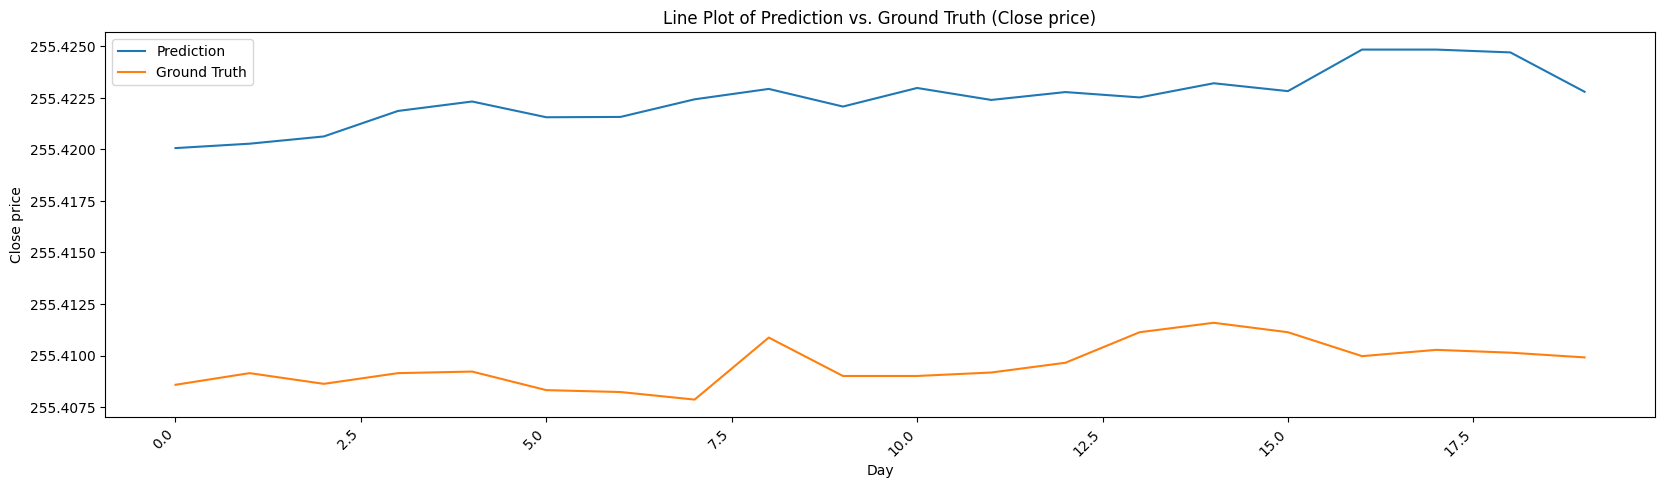

2024-08-29 20:33:51.303 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 20:33:51.339 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 20:33:51.394 
  command:

    streamlit run /home/samir-shrestha/Development/dlytica/stock_stan/venv/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-08-29 20:33:51.395 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Plot the data
plt.figure(figsize=(20, 5))
plt.plot(y_pred[-100], label="Prediction")
plt.plot(y_test[-100], label="Ground Truth")

# Set the labels and title
plt.xlabel("Day")
plt.ylabel("Close price")
plt.title("Line Plot of Prediction vs. Ground Truth (Close price)")

# Remove scientific notation and show true values on the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='y')

# Add a legend
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [7]:
torch.save(model.state_dict(),'assets/single_lstm_state.pt')

In [8]:
clean_normalized_df[-350:-230].shape

(120, 9)

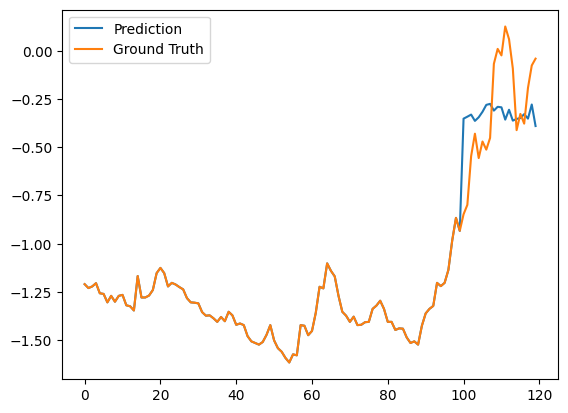

In [9]:
dummy=np.array(clean_normalized_df[-125:-5]).reshape(1,-1,9)
pred=model(torch.tensor(dummy[:,:-20,:],dtype=torch.float32))
plt.plot(np.concatenate((dummy[:,:-20,rolling_dataset.columns.get_loc('Close')].reshape(-1),pred.detach().numpy().reshape(-1))),label="Prediction")
plt.plot(dummy[:,:,clean_normalized_df.columns.get_loc('Close')].reshape(-1),label='Ground Truth')
plt.legend()
plt.show()


In [11]:
from statsmodels.tsa.arima.model import ARIMA
clean_df=pd.read_csv('assets/clean_data.csv')
series = clean_df['Close']

# Split data into train and test sets
train_size = int(len(series) * 0.8)
train, test = series[0:train_size], series[train_size:]
model = ARIMA(train,order=(1,1,0))  # Order is (p,d,q), tune accordingly
model_fit = model.fit()

Mean Absolute Error: 76.27283721568969


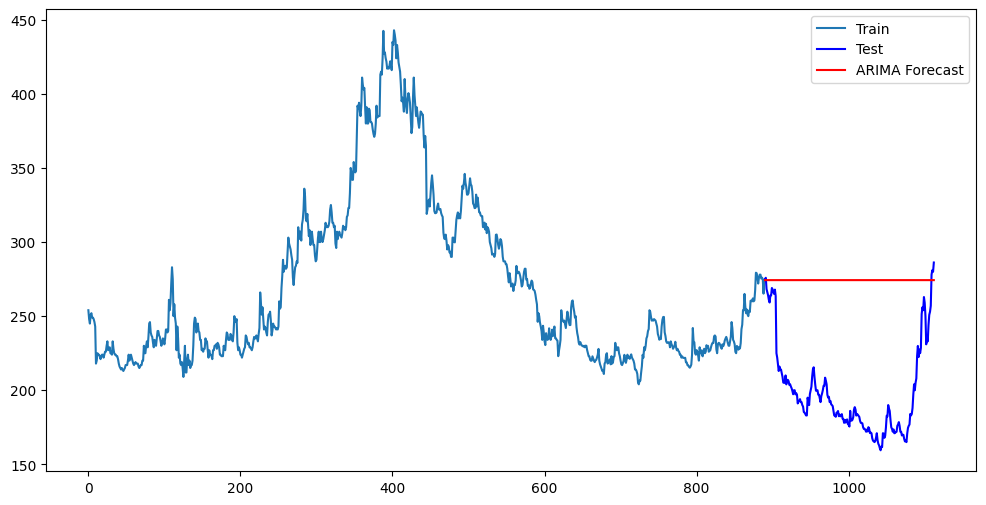

In [13]:
# Forecast
forecast = model_fit.forecast(len(test))
forecast = pd.Series(forecast, index=test.index)
from sklearn.metrics import mean_absolute_error
# Calculate error metrics
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='blue')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.show()